# Long Short-Term Memory (LSTM) Networks

LSTM networks, introduced by Hochreiter & Schmidhuber (1997), are a special type of Recurrent Neural Network (RNN) designed to overcome the **vanishing gradient problem** in traditional RNNs.

LSTMs can learn **long-term dependencies** by using a sophisticated gating mechanism that controls the flow of information through the network.

## Key Innovation: Memory Cell & Gates

Unlike simple RNNs, LSTMs have a **cell state** $C_t$ that acts as a "memory highway" running through the sequence, with three gates controlling information flow:

- *Forget Gate* $f_t$ - decides what information to discard from the cell state
- *Input Gate* $i_t$ - decides what new information to add to the cell state
- *Output Gate* $o_t$ - decides what information to output from the cell state

## LSTM Mathematical Formulation

At each time step $t$, given input $x_t$ and previous hidden state $h_{t-1}$:

**Forget Gate**

Controls what to forget from previous cell state:

$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$

**Input Gate**

Decides what new information to store:

$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$

**Candidate Cell State**

Creates candidate values to add to cell state:

$$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$

**Update Cell State**

Combines forget and input operations:

$$C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t$$

**Output Gate**

Decides what to output:

$$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$

**Hidden State**

Final output at this time step:

$$h_t = o_t \odot \tanh(C_t)$$

Notation

- $\sigma$ : sigmoid activation function (outputs values between 0 and 1)
- $\tanh$ : hyperbolic tangent activation (outputs values between -1 and 1)
- $\odot$ : element-wise multiplication (Hadamard product)
- $[h_{t-1}, x_t]$ : concatenation of previous hidden state and current input
- $W_f, W_i, W_C, W_o$ : weight matrices for gates
- $b_f, b_i, b_C, b_o$ : bias vectors

## Why LSTMs Work Better Than Simple RNNs

Memory:

- Simple RNN: only hidden state $h_t$
- LSTM: cell state $C_t$ + hidden state $h_t$

Gradient Flow:

- Simple RNN: suffers from vanishing/exploding gradients
- LSTM: gates allow stable gradient flow

Long Dependencies:

- Simple RNN: struggles with sequences greater than 10 steps
- LSTM: can learn dependencies over 100+ steps

Information Control:

- Simple RNN: no selective forgetting
- LSTM: gates selectively retain/forget

## Application to Financial Time Series

LSTMs are particularly well-suited for stock price prediction because:

- Sequential Dependencies: stock prices depend on historical patterns
- Long-term Trends: can capture both short-term fluctuations and long-term trends
- Variable-length Patterns: gates adapt to different market conditions
- Non-linear Relationships: can model complex market dynamics


## Setup - Package Installation

We'll install the required packages for stock data retrieval, LSTM modeling, and visualization.

In [1]:
import sys
import subprocess

packages = [
    'yfinance',
    'tensorflow',
    'matplotlib',
    'numpy',
    'pandas',
    'scikit-learn'
]

print("Installing required packages...")
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--quiet'] + packages)
print("✓ All packages installed successfully!")

Installing required packages...
✓ All packages installed successfully!


## Import Libraries

Import all required libraries and configure settings for reproducibility.

In [2]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Stock data retrieval
import yfinance as yf

# Machine learning and preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Deep learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Visualization
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure matplotlib style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10

print("✓ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✓ All libraries imported successfully!
TensorFlow version: 2.19.0
NumPy version: 1.26.4
Pandas version: 2.2.3


## Download Apple Stock Data

We'll download approximately 1 year of AAPL stock data (2024-2025) using the Yahoo Finance API.

In [3]:
# Define stock symbol and date range
ticker = "AAPL"
start_date = "2015-01-01"  # 10 years of data
end_date = "2025-01-01"

# Download stock data
print(f"Downloading {ticker} stock data from {start_date} to {end_date}...")
df = yf.download(ticker, start=start_date, end=end_date, progress=False)

# Extract Close price column
data = df[['Close']].copy()

# Display basic information
print(f"\n✓ Data downloaded successfully!")
print(f"\nDataset Shape: {data.shape}")
print(f"Date Range: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")
print(f"Total Trading Days: {len(data)}")

# Check for missing values
missing_values = data.isnull().sum().sum()
print(f"Missing Values: {missing_values}")

# Display first and last few rows
print("\nFirst 5 rows:")
print(data.head())
print("\nLast 5 rows:")
print(data.tail())

# Basic statistics
print("\nBasic Statistics:")
print(data.describe())

/var/folders/q5/_zmhq4652359tc3yz3d2pf400000gn/T/ipykernel_45075/1567749254.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)



✓ Data downloaded successfully!

Dataset Shape: (2516, 1)
Date Range: 2015-01-02 to 2024-12-31
Total Trading Days: 2516
Missing Values: 0

First 5 rows:
Price           Close
Ticker           AAPL
Date                 
2015-01-02  24.261047
2015-01-05  23.577574
2015-01-06  23.579788
2015-01-07  23.910433
2015-01-08  24.829132

Last 5 rows:
Price            Close
Ticker            AAPL
Date                  
2024-12-24  257.286682
2024-12-26  258.103729
2024-12-27  254.685883
2024-12-30  251.307877
2024-12-31  249.534180

Basic Statistics:
Price         Close
Ticker         AAPL
count   2516.000000
mean      93.949921
std       65.504728
min       20.624048
25%       35.257092
50%       64.450455
75%      150.379665
max      258.103729


## Visualize Raw Stock Data

Let's visualize the stock price trend over time to understand the data we're working with.

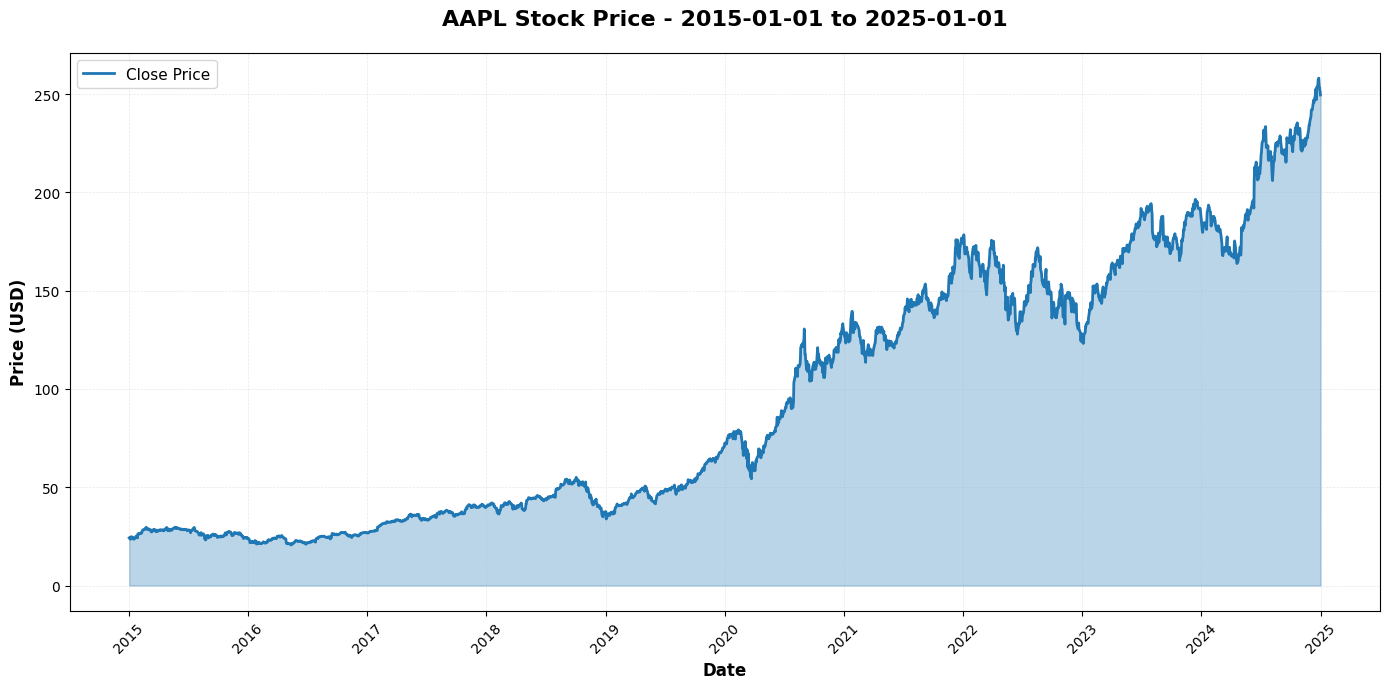


Price Range:
  Minimum: $20.62
  Maximum: $258.10
  Range: $237.48
  Average: $93.95


In [4]:
# Create visualization of stock price over time
plt.figure(figsize=(14, 7))

# Convert to numpy array to avoid dimension issues
close_prices = data['Close'].values.flatten()

# Plot closing prices
plt.plot(data.index, close_prices, color='#1f77b4', linewidth=2, label='Close Price')

# Fill area under the curve
plt.fill_between(data.index, close_prices, alpha=0.3, color='#1f77b4')

# Add title and labels
plt.title(f'{ticker} Stock Price - {start_date} to {end_date}', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Price (USD)', fontsize=12, fontweight='bold')

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Add legend
plt.legend(loc='upper left', fontsize=11)

# Format x-axis to show dates nicely
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

# Print price range
min_price = close_prices.min()
max_price = close_prices.max()
avg_price = close_prices.mean()

print(f"\nPrice Range:")
print(f"  Minimum: ${min_price:.2f}")
print(f"  Maximum: ${max_price:.2f}")
print(f"  Range: ${max_price - min_price:.2f}")
print(f"  Average: ${avg_price:.2f}")

## Data Preprocessing

### Data Normalization

Neural networks perform better when input features are normalized to a similar scale. We'll use MinMaxScaler to scale our stock prices to the range [0, 1].

Why normalization is important for LSTM:

- Prevents gradient explosion/vanishing during backpropagation
- Faster convergence during training
- Ensures all features contribute equally to the model
- Sigmoid and tanh activations work best with normalized inputs

In [5]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
# Note: We fit on all data here for simplicity, but in production
# you should fit only on training data to avoid data leakage
scaled_data = scaler.fit_transform(data.values)

# Get min and max values as scalars
min_price = data['Close'].values.min()
max_price = data['Close'].values.max()

print(f"✓ Data normalized successfully!")
print(f"\nOriginal data range:")
print(f"  Min: ${min_price:.2f}")
print(f"  Max: ${max_price:.2f}")

print(f"\nNormalized data range:")
print(f"  Min: {scaled_data.min():.4f}")
print(f"  Max: {scaled_data.max():.4f}")

print(f"\nShape: {scaled_data.shape}")
print(f"\nFirst 5 normalized values:")
print(scaled_data[:5].flatten())

✓ Data normalized successfully!

Original data range:
  Min: $20.62
  Max: $258.10

Normalized data range:
  Min: 0.0000
  Max: 1.0000

Shape: (2516, 1)

First 5 normalized values:
[0.01531499 0.01243696 0.01244629 0.01383859 0.01770713]


### Create Sliding Windows (60-Day Lookback)

This is the key step that demonstrates LSTM's long-term memory capability. We'll create windows of 60 consecutive days to predict the next day's price.

How it works:

- Days 1-60 → Predict Day 61
- Days 2-61 → Predict Day 62
- Days 3-62 → Predict Day 63
- And so on...

This 60-day lookback window allows the LSTM to learn long-term patterns and trends.

In [6]:
def create_sequences(data, seq_length=60):
    """
    Create sliding window sequences for LSTM training.
    
    Parameters:
    - data: normalized price data
    - seq_length: number of days to look back (default: 60)
    
    Returns:
    - X: input sequences of shape (samples, seq_length, 1)
    - y: target values of shape (samples, 1)
    """
    X, y = [], []
    
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])  # Past 60 days
        y.append(data[i, 0])                # Next day's price
    
    X, y = np.array(X), np.array(y)
    
    # Reshape X to be [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y

# Create sequences with 60-day lookback window
lookback_days = 60
X, y = create_sequences(scaled_data, lookback_days)

print(f"✓ Sliding windows created successfully!")
print(f"\nLookback window: {lookback_days} days")
print(f"\nInput shape (X): {X.shape}")
print(f"  - Samples: {X.shape[0]}")
print(f"  - Time steps: {X.shape[1]} (days)")
print(f"  - Features: {X.shape[2]} (close price)")

print(f"\nOutput shape (y): {y.shape}")
print(f"  - Samples: {y.shape[0]}")

print(f"\nExample:")
print(f"  First window (days 1-60) → predicts day 61")
print(f"  Last window (days {len(scaled_data)-60}-{len(scaled_data)-1}) → predicts day {len(scaled_data)}")

✓ Sliding windows created successfully!

Lookback window: 60 days

Input shape (X): (2456, 60, 1)
  - Samples: 2456
  - Time steps: 60 (days)
  - Features: 1 (close price)

Output shape (y): (2456,)
  - Samples: 2456

Example:
  First window (days 1-60) → predicts day 61
  Last window (days 2456-2515) → predicts day 2516


### Train/Test Split

We'll split the data into training (80%) and testing (20%) sets. 

**Important:** For time series data, we must preserve temporal order - no shuffling! The training data comes first chronologically, followed by the test data.

In [7]:
# Calculate split point (80% train, 20% test)
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

# Split the data (NO SHUFFLING - preserve temporal order!)
X_train = X[:split_index]
y_train = y[:split_index]

X_test = X[split_index:]
y_test = y[split_index:]

print(f"✓ Data split successfully!")
print(f"\nSplit ratio: {split_ratio*100:.0f}% train / {(1-split_ratio)*100:.0f}% test")
print(f"Split index: {split_index}")

print(f"\n{'='*50}")
print(f"TRAINING SET")
print(f"{'='*50}")
print(f"X_train shape: {X_train.shape}")
print(f"  - Samples: {X_train.shape[0]}")
print(f"  - Time steps: {X_train.shape[1]} days")
print(f"  - Features: {X_train.shape[2]}")
print(f"y_train shape: {y_train.shape}")

print(f"\n{'='*50}")
print(f"TESTING SET")
print(f"{'='*50}")
print(f"X_test shape: {X_test.shape}")
print(f"  - Samples: {X_test.shape[0]}")
print(f"  - Time steps: {X_test.shape[1]} days")
print(f"  - Features: {X_test.shape[2]}")
print(f"y_test shape: {y_test.shape}")

print(f"\n{'='*50}")
print(f"VERIFICATION")
print(f"{'='*50}")
print(f"Total samples: {len(X)}")
print(f"Train + Test: {len(X_train) + len(X_test)}")
print(f"Match: {'✓ Yes' if len(X) == len(X_train) + len(X_test) else '✗ No'}")

✓ Data split successfully!

Split ratio: 80% train / 20% test
Split index: 1964

TRAINING SET
X_train shape: (1964, 60, 1)
  - Samples: 1964
  - Time steps: 60 days
  - Features: 1
y_train shape: (1964,)

TESTING SET
X_test shape: (492, 60, 1)
  - Samples: 492
  - Time steps: 60 days
  - Features: 1
y_test shape: (492,)

VERIFICATION
Total samples: 2456
Train + Test: 2456
Match: ✓ Yes


## Model Building

We'll create a stacked LSTM architecture with dropout layers to prevent overfitting.

Architecture:

- 2 LSTM layers: First layer returns sequences for the second layer to process
- 50 units each: Balances model capacity with training time
- Dropout (20%): Prevents overfitting by randomly dropping connections during training
- Dense output: Single neuron predicting the next day's normalized price

In [8]:
# Build the LSTM model
print("Building LSTM model...")
print("="*60)

model = Sequential([
    # First LSTM layer - returns sequences for the next LSTM layer
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),  # 20% dropout to prevent overfitting
    
    # Second LSTM layer - doesn't return sequences (final LSTM layer)
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),  # 20% dropout
    
    # Dense output layer - predicts next day's normalized price
    Dense(units=1)
])

print("✓ Model architecture created successfully!")
print(f"\n{'='*60}")
print("MODEL ARCHITECTURE SUMMARY")
print(f"{'='*60}\n")

# Display model summary
model.summary()

print(f"\n{'='*60}")
print("ARCHITECTURE DETAILS")
print(f"{'='*60}")
print(f"Input Shape:     (60, 1) - 60 days of stock prices")
print(f"LSTM Layer 1:    50 units, return_sequences=True")
print(f"Dropout 1:       20% (prevents overfitting)")
print(f"LSTM Layer 2:    50 units, return_sequences=False")
print(f"Dropout 2:       20% (prevents overfitting)")
print(f"Output Layer:    1 unit (next day's price)")
print(f"\nTotal Parameters: {model.count_params():,}")

Building LSTM model...
✓ Model architecture created successfully!

MODEL ARCHITECTURE SUMMARY



/Users/andy/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)


ARCHITECTURE DETAILS
Input Shape:     (60, 1) - 60 days of stock prices
LSTM Layer 1:    50 units, return_sequences=True
Dropout 1:       20% (prevents overfitting)
LSTM Layer 2:    50 units, return_sequences=False
Dropout 2:       20% (prevents overfitting)
Output Layer:    1 unit (next day's price)

Total Parameters: 30,651


### Compile Model

Configure the optimizer, loss function, and metrics for training.

**Mean Squared Error (MSE)** measures the average squared difference between predicted and actual values:

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

where:

- $n$ = number of samples
- $y_i$ = actual price
- $\hat{y}_i$ = predicted price
- Squaring penalizes larger errors more heavily

**Mean Absolute Error (MAE)** measures the average absolute difference:

$$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

MAE is more interpretable (in same units as the target) and less sensitive to outliers than MSE.

In [9]:
# Compile the model
model.compile(
    optimizer='adam',              # Adam optimizer - adaptive learning rate
    loss='mean_squared_error',     # MSE for regression problems
    metrics=['mae']                # Mean Absolute Error as additional metric
)

print("✓ Model compiled successfully!")
print(f"\nOptimizer: Adam")
print(f"Loss Function: Mean Squared Error (MSE)")
print(f"Metrics: Mean Absolute Error (MAE)")

print(f"\n{'='*60}")
print("Model ready for training!")
print(f"{'='*60}")

✓ Model compiled successfully!

Optimizer: Adam
Loss Function: Mean Squared Error (MSE)
Metrics: Mean Absolute Error (MAE)

Model ready for training!


## Training

Now we'll train the model on 10 years of stock data with the 60-day lookback window. This is where the LSTM learns long-term patterns!

In [10]:
# Train the model
print("Starting training...")
print("="*60)

history = model.fit(
    X_train, y_train,
    epochs=50,                    # Number of training iterations
    batch_size=32,                # Samples per gradient update
    validation_split=0.1,         # Use 10% of training data for validation
    verbose=1,                    # Show progress bar
    shuffle=False                 # Don't shuffle (preserve temporal order)
)

print("\n" + "="*60)
print("✓ Training completed!")
print("="*60)

Starting training...
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.4674e-04 - mae: 0.0191 - val_loss: 0.0017 - val_mae: 0.0344
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0075 - mae: 0.0704 - val_loss: 0.0054 - val_mae: 0.0697
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0075 - mae: 0.0694 - val_loss: 0.0071 - val_mae: 0.0808
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0074 - mae: 0.0683 - val_loss: 7.9437e-04 - val_mae: 0.0230
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0021 - mae: 0.0381 - val_loss: 9.4050e-04 - val_mae: 0.0250
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.1062e-04 - mae: 0.0200 - val_loss: 6.3610e-04 - val_mae: 0.0210
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.0566e-04 - mae: 0.0102 - val_loss: 5.7201e-04 - val_mae: 0.0202
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.5802e-04 - mae: 0.0088 - val_loss: 4.9984e-04 - val_mae: 0.0188
Epoch 9

### Plot Training History

Visualize the training and validation loss/metrics to understand model convergence and check for overfitting.

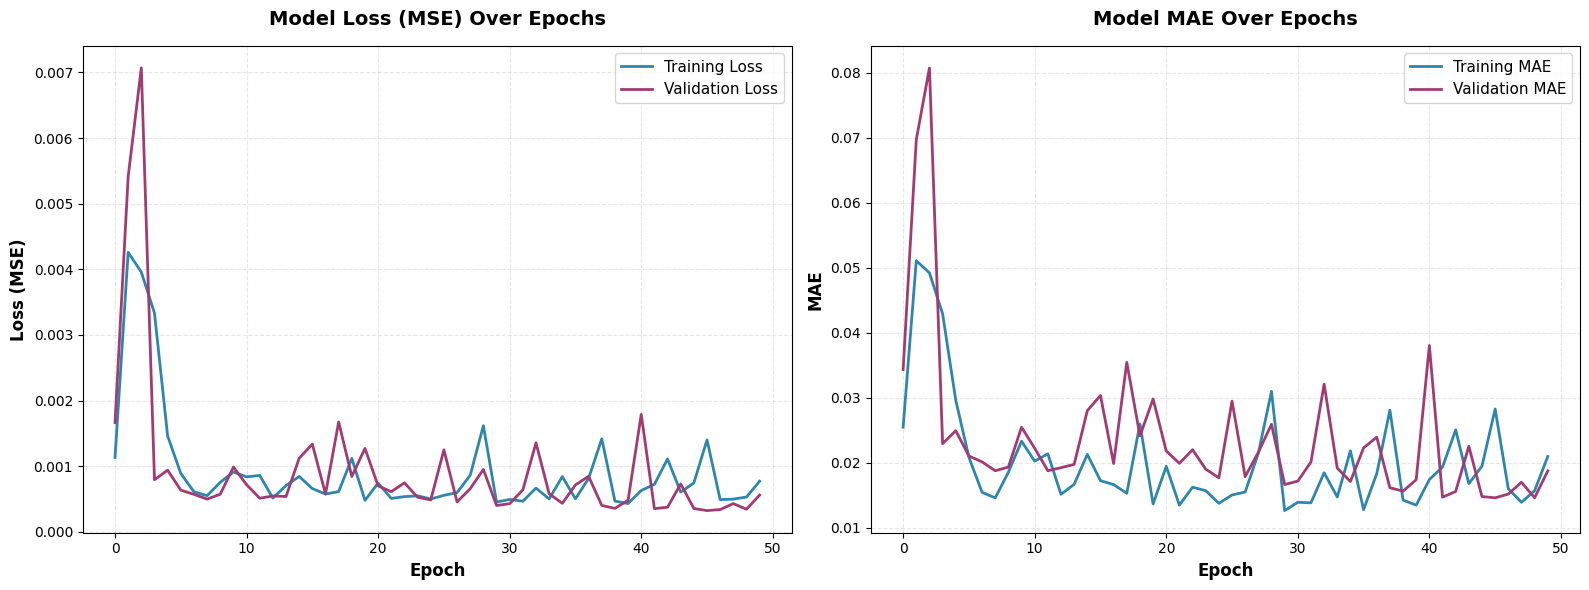


FINAL TRAINING METRICS
Training Loss (MSE):      0.000773
Validation Loss (MSE):    0.000561
Training MAE:             0.020972
Validation MAE:           0.018762

✓ Model shows good generalization


In [11]:
# Create subplots for loss and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Loss (MSE)
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, color='#2E86AB')
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#A23B72')
ax1.set_title('Model Loss (MSE) Over Epochs', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot 2: MAE
ax2.plot(history.history['mae'], label='Training MAE', linewidth=2, color='#2E86AB')
ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='#A23B72')
ax2.set_title('Model MAE Over Epochs', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('MAE', fontsize=12, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\n{'='*60}")
print("FINAL TRAINING METRICS")
print(f"{'='*60}")
print(f"Training Loss (MSE):      {history.history['loss'][-1]:.6f}")
print(f"Validation Loss (MSE):    {history.history['val_loss'][-1]:.6f}")
print(f"Training MAE:             {history.history['mae'][-1]:.6f}")
print(f"Validation MAE:           {history.history['val_mae'][-1]:.6f}")

# Check for overfitting
if history.history['val_loss'][-1] > history.history['loss'][-1] * 1.5:
    print(f"\n⚠️  Warning: Possible overfitting detected (val_loss >> train_loss)")
else:
    print(f"\n✓ Model shows good generalization")

## Evaluation & Prediction

**Make Predictions**

Use the trained model to predict stock prices on the test set, then transform them back to original scale.

In [12]:
# Make predictions on test data
print("Making predictions on test set...")
predictions = model.predict(X_test, verbose=0)

# Inverse transform to get actual price values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

print(f"✓ Predictions completed!")
print(f"\nPredictions shape: {predictions.shape}")
print(f"Actual values shape: {y_test_actual.shape}")

print(f"\n{'='*60}")
print("SAMPLE PREDICTIONS vs ACTUAL")
print(f"{'='*60}")
print(f"{'Index':<8} {'Predicted':<15} {'Actual':<15} {'Difference':<15}")
print(f"{'-'*60}")
for i in range(min(10, len(predictions))):
    pred = predictions[i][0]
    actual = y_test_actual[i][0]
    diff = pred - actual
    print(f"{i:<8} ${pred:<14.2f} ${actual:<14.2f} ${diff:<14.2f}")

print(f"\n✓ Ready for evaluation metrics and visualization!")

Making predictions on test set...
✓ Predictions completed!

Predictions shape: (492, 1)
Actual values shape: (492, 1)

SAMPLE PREDICTIONS vs ACTUAL
Index    Predicted       Actual          Difference     
------------------------------------------------------------
0        $135.78         $133.33         $2.45          
1        $136.60         $133.39         $3.22          
2        $137.11         $135.95         $1.15          
3        $137.89         $139.15         $-1.26         
4        $139.26         $140.55         $-1.29         
5        $140.86         $139.89         $0.97          
6        $142.08         $141.96         $0.12          
7        $143.33         $143.90         $-0.57         
8        $144.72         $141.01         $3.71          
9        $145.28         $142.28         $3.00          

✓ Ready for evaluation metrics and visualization!


### Calculate Evaluation Metrics

Quantify the model's performance using standard regression metrics.

In [13]:
# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
mae = mean_absolute_error(y_test_actual, predictions)
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100

# Calculate R² score (coefficient of determination)
from sklearn.metrics import r2_score
r2 = r2_score(y_test_actual, predictions)

print(f"{'='*60}")
print("MODEL EVALUATION METRICS")
print(f"{'='*60}")
print(f"\nRoot Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"  → Average prediction error magnitude")

print(f"\nMean Absolute Error (MAE):      ${mae:.2f}")
print(f"  → Average absolute difference from actual price")

print(f"\nMean Absolute % Error (MAPE):   {mape:.2f}%")
print(f"  → Average percentage error")

print(f"\nR² Score:                        {r2:.4f}")
print(f"  → Proportion of variance explained (1.0 = perfect)")

print(f"\n{'='*60}")
print("INTERPRETATION")
print(f"{'='*60}")

if mape < 5:
    quality = "Excellent"
elif mape < 10:
    quality = "Very Good"
elif mape < 15:
    quality = "Good"
else:
    quality = "Needs Improvement"

print(f"Model Quality: {quality} (MAPE: {mape:.2f}%)")
print(f"On average, predictions are off by ${mae:.2f}")

if r2 > 0.9:
    print(f"✓ Strong predictive power (R² = {r2:.4f})")
elif r2 > 0.7:
    print(f"✓ Good predictive power (R² = {r2:.4f})")
else:
    print(f"⚠ Moderate predictive power (R² = {r2:.4f})")

MODEL EVALUATION METRICS

Root Mean Squared Error (RMSE): $4.40
  → Average prediction error magnitude

Mean Absolute Error (MAE):      $3.39
  → Average absolute difference from actual price

Mean Absolute % Error (MAPE):   1.76%
  → Average percentage error

R² Score:                        0.9736
  → Proportion of variance explained (1.0 = perfect)

INTERPRETATION
Model Quality: Excellent (MAPE: 1.76%)
On average, predictions are off by $3.39
✓ Strong predictive power (R² = 0.9736)


### Visualize Predictions

Create a comprehensive visualization showing actual vs predicted stock prices across the entire dataset.

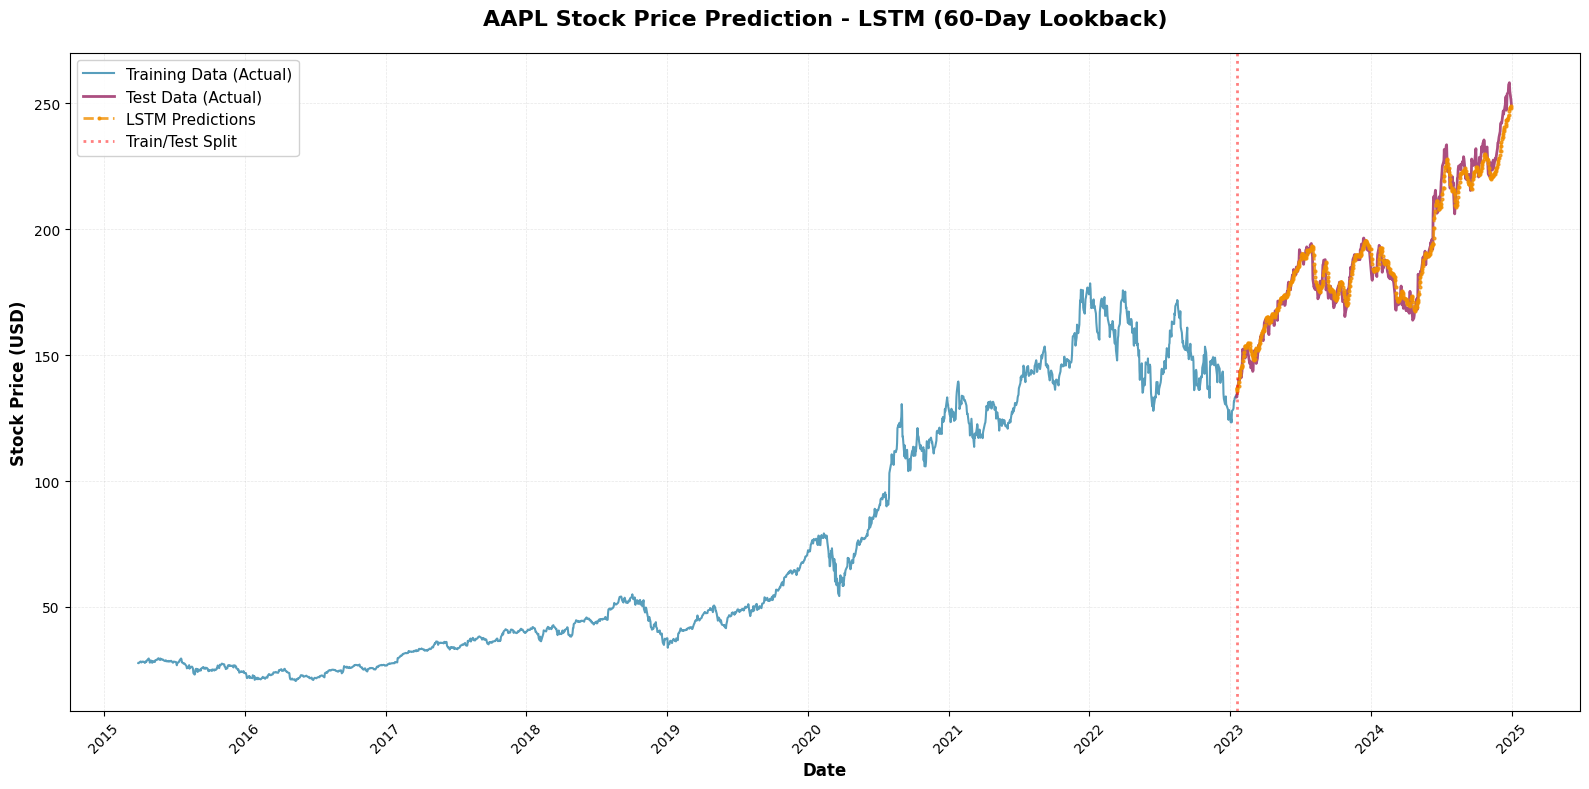


VISUALIZATION SUMMARY
Training Period: 2015-03-31 to 2023-01-17
Testing Period:  2023-01-18 to 2024-12-31
Total Days Visualized: 2456

The LSTM learned from 1964 days to predict 492 days
with a 60-day memory window demonstrating long-term learning!


In [14]:
# Prepare data for visualization
# Get the full dataset with proper indices
train_data = data.iloc[lookback_days:lookback_days+len(y_train)]
test_data = data.iloc[lookback_days+len(y_train):lookback_days+len(y_train)+len(y_test)]

# Create the plot
plt.figure(figsize=(16, 8))

# Plot training data
plt.plot(train_data.index, train_data['Close'], 
         color='#2E86AB', linewidth=1.5, label='Training Data (Actual)', alpha=0.8)

# Plot test data (actual)
plt.plot(test_data.index, test_data['Close'], 
         color='#A23B72', linewidth=2, label='Test Data (Actual)', alpha=0.9)

# Plot predictions
plt.plot(test_data.index, predictions, 
         color='#F18F01', linewidth=2, label='LSTM Predictions', 
         linestyle='--', marker='o', markersize=2, alpha=0.8)

# Add vertical line to separate train/test
split_date = test_data.index[0]
plt.axvline(x=split_date, color='red', linestyle=':', linewidth=2, alpha=0.5, label='Train/Test Split')

# Formatting
plt.title('AAPL Stock Price Prediction - LSTM (60-Day Lookback)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Stock Price (USD)', fontsize=12, fontweight='bold')
plt.legend(loc='upper left', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print summary
print(f"\n{'='*60}")
print("VISUALIZATION SUMMARY")
print(f"{'='*60}")
print(f"Training Period: {train_data.index[0].strftime('%Y-%m-%d')} to {train_data.index[-1].strftime('%Y-%m-%d')}")
print(f"Testing Period:  {test_data.index[0].strftime('%Y-%m-%d')} to {test_data.index[-1].strftime('%Y-%m-%d')}")
print(f"Total Days Visualized: {len(train_data) + len(test_data)}")
print(f"\nThe LSTM learned from {len(train_data)} days to predict {len(test_data)} days")
print(f"with a {lookback_days}-day memory window demonstrating long-term learning!")

## Future Predictions

**Predict Next 10 Days (January 2025)**

Now we'll use the trained model to predict the next 10 trading days in January 2025 by recursively feeding predictions back into the model.

In [15]:
# Predict next 10 days in January 2025
print("Predicting next 10 trading days in January 2025...")
print("="*60)

# Get the last 60 days from the dataset to use as initial input
last_60_days = scaled_data[-lookback_days:]

# Prepare for recursive prediction
future_predictions = []
current_sequence = last_60_days.copy()

# Predict 10 days into the future
num_future_days = 10

for i in range(num_future_days):
    # Reshape current sequence for prediction
    current_input = current_sequence.reshape(1, lookback_days, 1)
    
    # Make prediction
    next_prediction = model.predict(current_input, verbose=0)
    
    # Store the prediction
    future_predictions.append(next_prediction[0, 0])
    
    # Update sequence: remove first value, append new prediction
    current_sequence = np.append(current_sequence[1:], next_prediction[0, 0])
    current_sequence = current_sequence.reshape(-1, 1)

# Convert predictions back to original price scale
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions_prices = scaler.inverse_transform(future_predictions)

# Create future dates (business days in January 2025)
from datetime import datetime, timedelta
import pandas as pd

# Start from the last date in our dataset
last_date = data.index[-1]
future_dates = pd.bdate_range(start=last_date + timedelta(days=1), periods=num_future_days)

# Display predictions
print(f"\n✓ Future predictions completed!")
print(f"\n{'='*60}")
print(f"NEXT 10 TRADING DAYS PREDICTIONS (January 2025)")
print(f"{'='*60}")
print(f"{'Date':<15} {'Day':<5} {'Predicted Price':<20}")
print(f"{'-'*60}")

for i, (date, price) in enumerate(zip(future_dates, future_predictions_prices)):
    day_name = date.strftime('%a')
    date_str = date.strftime('%Y-%m-%d')
    print(f"{date_str:<15} {day_name:<5} ${price[0]:<19.2f}")

# Calculate statistics - FIX: Convert to scalar values
avg_future_price = float(future_predictions_prices.mean())
last_actual_price = float(data['Close'].iloc[-1])  # Use iloc instead of values
price_change = future_predictions_prices[-1][0] - last_actual_price
price_change_pct = (price_change / last_actual_price) * 100

print(f"\n{'='*60}")
print("PREDICTION SUMMARY")
print(f"{'='*60}")
print(f"Last Actual Price (2024-12-31): ${last_actual_price:.2f}")
print(f"First Prediction (Day 1):        ${future_predictions_prices[0][0]:.2f}")
print(f"Last Prediction (Day 10):         ${future_predictions_prices[-1][0]:.2f}")
print(f"Average Predicted Price:          ${avg_future_price:.2f}")
print(f"\nPredicted 10-Day Change:          ${price_change:.2f} ({price_change_pct:+.2f}%)")

if price_change > 0:
    trend = "BULLISH"
else:
    trend = "BEARISH"

print(f"Predicted Trend:                  {trend}")
print(f"{'='*60}")

Predicting next 10 trading days in January 2025...

✓ Future predictions completed!

NEXT 10 TRADING DAYS PREDICTIONS (January 2025)
Date            Day   Predicted Price     
------------------------------------------------------------
2025-01-01      Wed   $247.04             
2025-01-02      Thu   $245.40             
2025-01-03      Fri   $243.61             
2025-01-06      Mon   $241.77             
2025-01-07      Tue   $239.96             
2025-01-08      Wed   $238.19             
2025-01-09      Thu   $236.49             
2025-01-10      Fri   $234.84             
2025-01-13      Mon   $233.26             
2025-01-14      Tue   $231.75             

PREDICTION SUMMARY
Last Actual Price (2024-12-31): $249.53
First Prediction (Day 1):        $247.04
Last Prediction (Day 10):         $231.75
Average Predicted Price:          $239.23

Predicted 10-Day Change:          $-17.79 (-7.13%)
Predicted Trend:                  BEARISH


/var/folders/q5/_zmhq4652359tc3yz3d2pf400000gn/T/ipykernel_45075/330820416.py:56: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_actual_price = float(data['Close'].iloc[-1])  # Use iloc instead of values
